In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.font_manager as fm
from textwrap import wrap


prop = fm.FontProperties(fname='../plots/arial.ttf')

plt.rcParams['ps.useafm'] = True
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

from statsmodels.stats.multitest import multipletests

import sys
import os

sys.path.append(os.path.relpath("../../huygens"))
sys.path.append(os.path.relpath("../../galileo"))
import galileo as gal
import huygens as huy

from itertools import combinations,chain
import upsetplot

import json

import helper

# Define experiments

In [76]:
with open("experiments.json","r") as f:
    exp = json.load(f)
    
    experiments = exp["experiments"]
    experiment_ids = exp["experiment_ids"]
    display_names = exp["display_names"]
    display_groups = exp["display_groups"]
    contexts = exp["contexts"]


# Load TPMS and sleuth results

In [3]:
kallisto_sleuth_path = "../data/processed/kallisto_sleuth_merge/"

rpl22_oe_genes = pd.read_hdf(kallisto_sleuth_path + "rpl22_oe_genes.h5", key="sleuth_diff")
rpl22l1_oe_genes = pd.read_hdf(kallisto_sleuth_path + "rpl22l1_oe_genes.h5", key="sleuth_diff")
rpl22l1_kd1_genes = pd.read_hdf(kallisto_sleuth_path + "rpl22l1_kd1_genes.h5", key="sleuth_diff")
rpl22l1_kd2_genes = pd.read_hdf(kallisto_sleuth_path + "rpl22l1_kd2_genes.h5", key="sleuth_diff")
rpl22_a_ko1_genes = pd.read_hdf(kallisto_sleuth_path + "rpl22_a_ko1_genes.h5", key="sleuth_diff")
rpl22_a_ko2_genes = pd.read_hdf(kallisto_sleuth_path + "rpl22_a_ko2_genes.h5", key="sleuth_diff")
rpl22_b_ko1_genes = pd.read_hdf(kallisto_sleuth_path + "rpl22_b_ko1_genes.h5", key="sleuth_diff")
rpl22_b_ko2_genes = pd.read_hdf(kallisto_sleuth_path + "rpl22_b_ko2_genes.h5", key="sleuth_diff")

rpl22_oe_transcripts = pd.read_hdf(kallisto_sleuth_path + "rpl22_oe_transcripts.h5", key="sleuth_diff")
rpl22l1_oe_transcripts = pd.read_hdf(kallisto_sleuth_path + "rpl22l1_oe_transcripts.h5", key="sleuth_diff")
rpl22l1_kd1_transcripts = pd.read_hdf(kallisto_sleuth_path + "rpl22l1_kd1_transcripts.h5", key="sleuth_diff")
rpl22l1_kd2_transcripts = pd.read_hdf(kallisto_sleuth_path + "rpl22l1_kd2_transcripts.h5", key="sleuth_diff")
rpl22_a_ko1_transcripts = pd.read_hdf(kallisto_sleuth_path + "rpl22_a_ko1_transcripts.h5", key="sleuth_diff")
rpl22_a_ko2_transcripts = pd.read_hdf(kallisto_sleuth_path + "rpl22_a_ko2_transcripts.h5", key="sleuth_diff")
rpl22_b_ko1_transcripts = pd.read_hdf(kallisto_sleuth_path + "rpl22_b_ko1_transcripts.h5", key="sleuth_diff")
rpl22_b_ko2_transcripts = pd.read_hdf(kallisto_sleuth_path + "rpl22_b_ko2_transcripts.h5",key="sleuth_diff")

# Differential expression

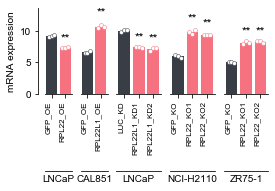

In [31]:
import importlib
importlib.reload(helper)

helper.all_bars("ENSG00000163584","gene")

plt.savefig("../plots/RPL22L1_ENSG00000163584_expression.pdf",bbox_inches="tight",transparent=True)

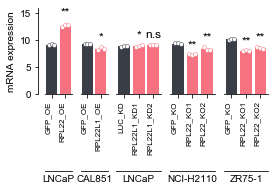

In [32]:
helper.all_bars("ENSG00000116251","gene")

plt.savefig("../plots/RPL22_ENSG00000116251_expression.pdf",bbox_inches="tight",transparent=True)

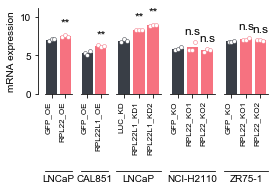

In [34]:
helper.all_bars("ENSG00000135679","gene")

plt.savefig("../plots/MDM2_ENSG00000135679_expression.pdf",bbox_inches="tight",transparent=True)

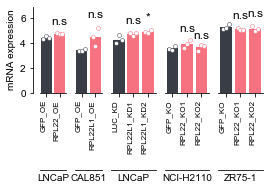

In [33]:
helper.all_bars("ENSG00000198625","gene")

plt.savefig("../plots/MDM4_ENSG00000198625_expression.pdf",bbox_inches="tight",transparent=True)

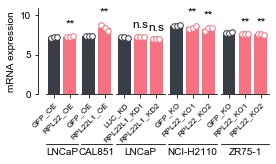

In [10]:
helper.all_bars("ENSG00000143569","gene")

plt.savefig("../plots/UBAP2L_ENSG00000143569_expression.pdf",bbox_inches="tight",transparent=True)

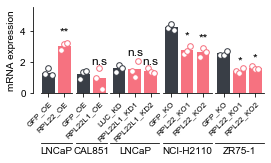

In [11]:
helper.all_bars("ENST00000484819","transcript")

plt.savefig("../plots/UBAP2L_ENST00000484819_expression.pdf",bbox_inches="tight",transparent=True)

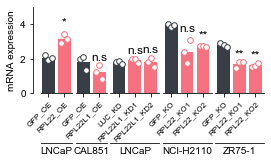

In [12]:
helper.all_bars("ENST00000433615","transcript")

plt.savefig("../plots/UBAP2L_ENST00000433615_expression.pdf",bbox_inches="tight",transparent=True)

## Volcano plots

# Overlaps

In [35]:
def get_overlaps(diffs,names,cutoff=0.01, direction=None, filter_empty=True):
    
    assert len(diffs)==len(names),"Length of diffs and names should match"

    n_diffs = len(diffs)
    all_subset_indices = list(chain(*[combinations(range(n_diffs), i) for i in range(1,n_diffs+1)]))
    
    significants = []
    
    for diff in diffs:
        
        if direction == None:
        
            significant = diff.copy(deep=True)[diff["qval"]<cutoff]
            
        if direction == "pos":
            
            significant = diff.copy(deep=True)[diff["qval"]<cutoff]
            significant = significant[significant["treatment_increase"]==1]
            
        elif direction == "neg":
            
            significant = diff.copy(deep=True)[diff["qval"]<cutoff]
            significant = significant[significant["treatment_increase"]==-1]
        
        significant["gene"] = significant["hgnc_gene"].fillna("nan") + "_" + pd.Series(significant.index,index=significant.index)
        
        significant_genes = set(significant["gene"])
        
        significants.append(significant_genes)
        
    intersections = []
    intersection_names = []
        
    for subset_indices in all_subset_indices:
        
        select_significants = set.intersection(*[significants[i] for i in subset_indices])
                
        if len(subset_indices) < n_diffs:
        
            select_insignificants = set.union(*[significants[i] for i in range(n_diffs) if i not in subset_indices])
        
            select_significants = select_significants - select_insignificants
        
        select_names = [names[i] for i in subset_indices]
        
        intersections.append(select_significants)
        intersection_names.append(select_names)
        
    intersection_sizes = [len(x) for x in intersections]
    
    if filter_empty:
        
        n_subsets = len(intersections)
        
        empty = [len(x) == 0 for x in intersections]
        
        intersections = [intersections[i] for i in range(n_subsets) if not empty[i]]
        intersection_names = [intersection_names[i] for i in range(n_subsets) if not empty[i]]
        intersection_sizes = [intersection_sizes[i] for i in range(n_subsets) if not empty[i]]
        
    return intersections,intersection_names,intersection_sizes

## Between RPL22L1 shRNAs

In [36]:
rpl22_int_rmats = [
    rpl22_b_ko2_transcripts,
    rpl22_b_ko1_transcripts,
    rpl22_a_ko2_transcripts,
    rpl22_a_ko1_transcripts,
    rpl22_oe_transcripts
]

rpl22_int_display_names = [
    "ZR75-1 RPL22_KO2",
    "ZR75-1 RPL22_KO1",
    "NCI-H2110 RPL22_KO2",
    "NCI-H2110 RPL22_KO1",
    "LNCaP RPL22_OE"
]

rpl22_ko_ints, rpl22_ko_int_names, rpl22_ko_int_sizes = get_overlaps(rpl22_int_rmats,rpl22_int_display_names)

In [61]:
rpl22_ko_ints[-1]

{'RPL22L1_ENST00000295830',
 'RPL22L1_ENST00000463836',
 'RPL22_ENST00000234875',
 'UBAP2L_ENST00000484819'}

In [37]:
rpl22_ko_pivot = upsetplot.from_memberships(rpl22_ko_int_names,rpl22_ko_int_sizes)

rpl22_ko_pivot = rpl22_ko_pivot.reorder_levels(rpl22_int_display_names)

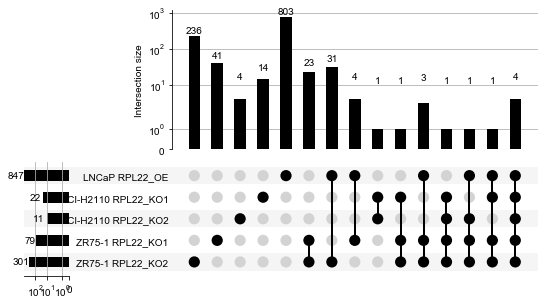

In [56]:
up = upsetplot.plot(rpl22_ko_pivot,
                    sort_categories_by=None, 
                    show_counts=True
                   )

up["intersections"].set_yscale("symlog")

# up["intersections"].set_ylim(0.5)

# for patch in up["intersections"]:
#     patch.set_rasterized(True)

plt.savefig("../plots/RPL22_transcript_intersections.pdf",transparent=True,bbox_inches="tight",dpi=25)

In [57]:
rpl22l1_int_rmats = [
    rpl22l1_kd2_transcripts,
    rpl22l1_kd1_transcripts,
    rpl22l1_oe_transcripts
]

rpl22l1_int_display_names = [
    "LNCaP RPL22L1_KD2",
    "LNCaP RPL22L1_KD1",
    "CAL851 RPL22L1_OE"
]

rpl22l1_ko_ints, rpl22l1_ko_int_names, rpl22l1_ko_int_sizes = get_overlaps(rpl22l1_int_rmats,rpl22l1_int_display_names)

In [58]:
rpl22l1_ko_pivot = upsetplot.from_memberships(rpl22l1_ko_int_names,rpl22l1_ko_int_sizes)

rpl22l1_ko_pivot = rpl22l1_ko_pivot.reorder_levels(rpl22l1_int_display_names)

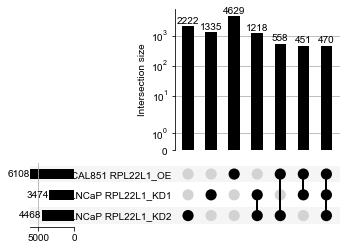

In [60]:
up = upsetplot.plot(rpl22l1_ko_pivot,
                    sort_categories_by=None,
                    show_counts=True
                    )

up["intersections"].set_yscale("symlog")

plt.savefig("../plots/RPL22L1_transcript_intersections.pdf",
            transparent=True, bbox_inches="tight")

# fgsea results

In [88]:
rpl22_oe_fgsea = pd.read_csv("../data/processed/fgsea_results/rpl22_oe.txt",sep="\t",index_col=0)
rpl22l1_oe_fgsea = pd.read_csv("../data/processed/fgsea_results/rpl22l1_oe.txt",sep="\t",index_col=0)
rpl22l1_kd1_fgsea = pd.read_csv("../data/processed/fgsea_results/rpl22l1_kd1.txt",sep="\t",index_col=0)
rpl22l1_kd2_fgsea = pd.read_csv("../data/processed/fgsea_results/rpl22l1_kd2.txt",sep="\t",index_col=0)
rpl22_a_ko1_fgsea = pd.read_csv("../data/processed/fgsea_results/rpl22_a_ko1.txt",sep="\t",index_col=0)
rpl22_a_ko2_fgsea = pd.read_csv("../data/processed/fgsea_results/rpl22_a_ko2.txt",sep="\t",index_col=0)
rpl22_b_ko1_fgsea = pd.read_csv("../data/processed/fgsea_results/rpl22_b_ko1.txt",sep="\t",index_col=0)
rpl22_b_ko2_fgsea = pd.read_csv("../data/processed/fgsea_results/rpl22_b_ko2.txt",sep="\t",index_col=0)

def preprocess_fgsea(fgsea):
    fgsea.sort_values(by="padj",inplace=True)
    fgsea.index = fgsea["pathway"]
    fgsea["gene_set"] = fgsea["pathway"].str.split("_").str[0]
    fgsea["direction"] = fgsea["NES"] > 0
    
preprocess_fgsea(rpl22_oe_fgsea)
preprocess_fgsea(rpl22l1_oe_fgsea)
preprocess_fgsea(rpl22l1_kd1_fgsea)
preprocess_fgsea(rpl22l1_kd2_fgsea)
preprocess_fgsea(rpl22_a_ko1_fgsea)
preprocess_fgsea(rpl22_a_ko2_fgsea)
preprocess_fgsea(rpl22_b_ko1_fgsea)
preprocess_fgsea(rpl22_b_ko2_fgsea)

# same order as display_names
fgseas = [
    rpl22_oe_fgsea,
    rpl22l1_oe_fgsea,
    rpl22l1_kd1_fgsea,
    rpl22l1_kd2_fgsea,
    rpl22_a_ko1_fgsea,
    rpl22_a_ko2_fgsea,
    rpl22_b_ko1_fgsea,
    rpl22_b_ko2_fgsea
]



In [159]:
select_names = display_names[:4]
select_gseas = fgseas[:4]


top_n = 4
    
top_sets = pd.Index([])

for gsea in select_gseas:

    top = gsea.sort_values(by="pval").head(top_n)
    
    top = top[top["padj"]<0.01]
    
    top = top.index

    top_sets = top_sets | top
    
set_count = len(top_sets)
    
tops = [x.loc[top_sets] for x in select_gseas]


qvals = [x["padj"] for x in tops]
sizes = [x["size"] for x in tops]
directions = [x["direction"] for x in tops]

qvals = pd.concat(qvals)
sizes = pd.concat(sizes)
directions = pd.concat(directions)

experiments = np.repeat(display_names,top_n)

experiment_coords = np.repeat(np.arange(len(select_names)),set_count)
gene_set_coords = list(range(set_count))*len(select_names)

merged_top_gsea = pd.DataFrame()
merged_top_gsea["qval"] = list(qvals)
merged_top_gsea["size"] = list(sizes)
merged_top_gsea["direction"] = list(directions)
merged_top_gsea["direction"] = merged_top_gsea["direction"].replace({True:"Upregulated",False:"Downregulated"})
merged_top_gsea["experiment_coord"] = experiment_coords
merged_top_gsea["gene_set_coord"] = gene_set_coords

merged_top_gsea = merged_top_gsea[merged_top_gsea["qval"]<0.1]

[Text(0, 0, 'GO_ALCOHOL_BIOSYNTHETIC_PROCESS'),
 Text(0, 0, 'GO_CHROMOSOME_SEGREGATION'),
 Text(0, 0, 'GO_COLLAGEN_CONTAINING_EXTRACELLULAR_MATRIX'),
 Text(0, 0, 'GO_EXTRACELLULAR_MATRIX'),
 Text(0, 0, 'GO_MRNA_METABOLIC_PROCESS'),
 Text(0, 0, 'GO_NUCLEAR_CHROMOSOME_SEGREGATION'),
 Text(0, 0, 'GO_REGULATION_OF_SMALL_MOLECULE_METABOLIC_PROCESS'),
 Text(0, 0, 'GO_RNA_SPLICING'),
 Text(0, 0, 'GO_STEROID_BIOSYNTHETIC_PROCESS'),
 Text(0, 0, 'GO_STEROL_BIOSYNTHETIC_PROCESS'),
 Text(0, 0, 'HALLMARK_G2M_CHECKPOINT'),
 Text(0, 0, 'HALLMARK_P53_PATHWAY')]

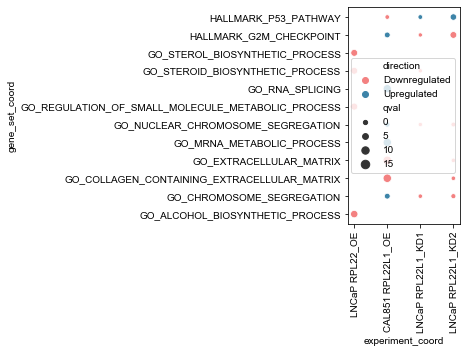

In [160]:
plt.figure(figsize=(2,4))
ax = plt.subplot(111)

sns.scatterplot(
    merged_top_gsea["experiment_coord"], 
    merged_top_gsea["gene_set_coord"],
    size=-np.log10(merged_top_gsea["qval"]),
    hue=merged_top_gsea["direction"],
    ax=ax,
    palette={"Upregulated":"#3d84a8","Downregulated":"#f38181"}
)

ax.set_xticks(np.arange(len(select_names)))
ax.set_xticklabels(select_names, rotation=90)
ax.set_yticks(np.arange(len(top_sets)))
ax.set_yticklabels(top_sets)

In [120]:
display_names

['LNCaP RPL22_OE',
 'CAL851 RPL22L1_OE',
 'LNCaP RPL22L1_KD1',
 'LNCaP RPL22L1_KD2',
 'NCI-H2110 RPL22_KO1',
 'NCI-H2110 RPL22_KO2',
 'ZR75-1 RPL22_KO1',
 'ZR75-1 RPL22_KO2']

In [79]:
rpl22_oe_fgsea.head()

,pathway,pval,padj,log2err,ES,NES,size,leadingEdge,gene_set,direction
pathway,,,,,,,,,,
GO_ALCOHOL_BIOSYNTHETIC_PROCESS,GO_ALCOHOL_BIOSYNTHETIC_PROCESS,1.885562e-14,8.537825e-11,0.975995,-0.902060,-2.143156,129,"2224,2222,79071,3638,6713,3157,39,4047,3422,45...",GO,False
GO_REGULATION_OF_SMALL_MOLECULE_METABOLIC_PROCESS,GO_REGULATION_OF_SMALL_MOLECULE_METABOLIC_PROCESS,1.823241e-13,4.127817e-10,0.943632,-0.810018,-2.075172,257,"2224,3949,2222,79071,3638,6713,3157,4047,3422,...",GO,False
GO_REGULATION_OF_LIPID_BIOSYNTHETIC_PROCESS,GO_REGULATION_OF_LIPID_BIOSYNTHETIC_PROCESS,8.585274e-13,1.295804e-09,0.921426,-0.882122,-2.103055,133,"2224,3949,2222,79071,3638,6713,3157,4047,3422,...",GO,False
GO_STEROID_BIOSYNTHETIC_PROCESS,GO_STEROID_BIOSYNTHETIC_PROCESS,1.200873e-12,1.359388e-09,0.910120,-0.882561,-2.101602,134,"2224,2222,79071,3638,6713,3157,39,4047,3422,45...",GO,False
GO_STEROL_BIOSYNTHETIC_PROCESS,GO_STEROL_BIOSYNTHETIC_PROCESS,2.961669e-11,2.682088e-08,0.851339,-0.941117,-2.051815,65,"2224,2222,79071,3638,6713,3157,39,4047,3422,45...",GO,False


In [19]:
def get_top_n(fgsea, n=4):
#     positives = fgsea[fgsea["direction"]==True].head(n)
#     negatives = fgsea[fgsea["direction"]==False].head(n)

    return fgsea.head(n*2)
    
#     return pd.concat([positives,negatives],axis=0).sort_values(by="pval")

rpl22_oe_fgsea_top = get_top_n(rpl22_oe_fgsea)
rpl22l1_oe_fgsea_top = get_top_n(rpl22l1_oe_fgsea)
rpl22l1_kd1_fgsea_top = get_top_n(rpl22l1_kd1_fgsea)
rpl22l1_kd2_fgsea_top = get_top_n(rpl22l1_kd2_fgsea)
rpl22_a_ko1_fgsea_top = get_top_n(rpl22_a_ko1_fgsea)
rpl22_a_ko2_fgsea_top = get_top_n(rpl22_a_ko2_fgsea)
rpl22_b_ko1_fgsea_top = get_top_n(rpl22_b_ko1_fgsea)
rpl22_b_ko2_fgsea_top = get_top_n(rpl22_b_ko2_fgsea)

In [20]:
fgsea = rpl22l1_oe_fgsea_top


def plot_top(fgsea_top, ax=None, legend=False):

    if ax is None:

        ax = plt.subplot(111)

    g = sns.scatterplot(
        -np.log10(fgsea_top["padj"]),
        np.arange(8),
        size=fgsea_top["size"].rename("Gene set size"),
        hue=(fgsea_top["NES"] > 0).replace(
            {True: "Upregulated", False: "Downregulated"}).rename("Expression change,\ntreatment"),
        sizes=(40, 250),
        size_norm=(0, 500),
        palette={"Upregulated": "#3f72af", "Downregulated": "#e23e57"},
        ax=ax,
        legend=legend
    )
    
    if legend:
        g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)   

    ax.set_xlim(0, plt.xlim()[1]*1.1)


    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.spines['bottom'].set_position(('axes', -0.025))
    ax.spines['left'].set_position(('axes', -0.05))

    ax.set_xlabel("-log10(q-value)")
    ax.set_yticks(np.arange(8))
    
    ylabels = fgsea_top["pathway"].apply(
        lambda x: x.replace("_", " ").capitalize())
    
    ylabels = ylabels.apply(lambda x: x.replace("Go ","").replace(" process","").capitalize())
    
    ax.set_yticklabels(ylabels)

    return ax

In [63]:
rpl22_oe_fgsea_top

NameError: name 'rpl22_oe_fgsea_top' is not defined

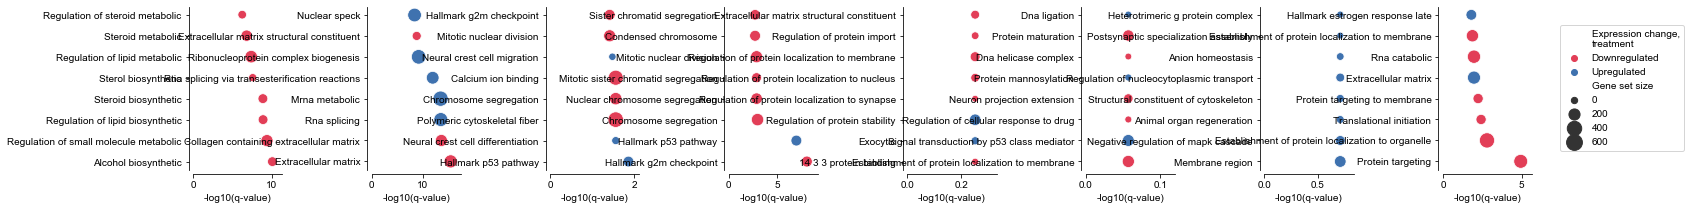

In [21]:
plt.figure(figsize=(24,3))
plot_top(rpl22_oe_fgsea_top,plt.subplot(181))
plot_top(rpl22l1_oe_fgsea_top,plt.subplot(182))
plot_top(rpl22l1_kd1_fgsea_top,plt.subplot(183))
plot_top(rpl22l1_kd2_fgsea_top,plt.subplot(184))
plot_top(rpl22_a_ko1_fgsea_top,plt.subplot(185))
plot_top(rpl22_a_ko2_fgsea_top,plt.subplot(186))
plot_top(rpl22_b_ko1_fgsea_top,plt.subplot(187))
plot_top(rpl22_b_ko2_fgsea_top,plt.subplot(188),legend='brief')


plt.subplots_adjust(wspace=1)

# plt.savefig("../plots/fgsea_top.pdf",bbox_inches="tight",transparent=True)